In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat, savemat
from scipy.stats import gaussian_kde
import chaospy as cp
import numpoly
import seaborn as sns

In [2]:
### GENERATE INPUT DISTRIBUTIONS ###
np.random.seed(1)

E_s_mean = 200e6
E_s_range = 100e6
E_h_mean = 200e9
E_h_range = 100e9

rho_s_mean = 1e3
rho_s_range = 5e2
rho_h_mean = 8e3
rho_h_range = 4e3

pr_h_mean = 0.25
pr_h_range = 0.25
pr_s_mean = 0.25
pr_s_range = 0.25

E_soft_dist = cp.Uniform(E_s_mean-E_s_range, E_s_mean+E_s_range)
E_hard_dist = cp.Uniform(E_h_mean-E_h_range, E_h_mean+E_h_range)
rho_soft_dist = cp.Uniform(rho_s_mean-rho_s_range, rho_s_mean+rho_s_range)
rho_hard_dist = cp.Uniform(rho_h_mean-rho_h_range, rho_h_mean+rho_h_range)
pr_soft_dist = cp.Uniform(pr_s_mean-pr_s_range, pr_s_mean+pr_s_range)
pr_hard_dist = cp.Uniform(pr_h_mean-pr_h_range, pr_h_mean+pr_h_range)
joint_dist = cp.J(E_soft_dist, E_hard_dist, rho_soft_dist, rho_hard_dist, pr_soft_dist, pr_hard_dist)

In [3]:
degrees = [2, 3, 4, 5]
quadrature_surrogates = {}
quadrature_nodes = {}
quadrature_weights = {}
for d in degrees:
    nodes, weights = cp.generate_quadrature(d, joint_dist, rule='G')
    #nodes, weights = cp.quadrature.legendre(order=d, lower=E_soft_dist.lower, upper=E_soft_dist.upper)
    quadrature_nodes[d] = nodes
    quadrature_weights[d] = weights

#quadrature_nodes

for qd in quadrature_nodes:
    savemat('joint_dist_pd_'+str(qd)+'.mat',{'pd_'+str(qd)+'_inputs':quadrature_nodes[qd]})

In [4]:
E_soft_sample_sets = {}
E_hard_sample_sets = {}
rho_soft_sample_sets = {}
rho_hard_sample_sets = {}
pr_soft_sample_sets = {}
pr_hard_sample_sets = {}
bg_size_sample_sets = {}
bg_top_sample_sets = {}
bg_bottom_sample_sets = {}
bg_center_sample_sets = {}

for d in degrees:
    folder_name = 'quad_6i_pd'+str(d)
    file_suffix = '_q_pd'+str(d)+'_uniform_'+str((d+1)**6)+'.mat'
    E_soft_file = loadmat(folder_name+'/E_soft'+file_suffix)
    E_hard_file = loadmat(folder_name+'/E_hard'+file_suffix)
    rho_soft_file = loadmat(folder_name+'/rho_soft'+file_suffix)
    rho_hard_file = loadmat(folder_name+'/rho_hard'+file_suffix)
    pr_soft_file = loadmat(folder_name+'/pr_soft'+file_suffix)
    pr_hard_file = loadmat(folder_name+'/pr_hard'+file_suffix)
    bg_size_file = loadmat(folder_name+'/bg_size'+file_suffix)
    bg_top_file = loadmat(folder_name+'/bg_top'+file_suffix)
    bg_bottom_file = loadmat(folder_name+'/bg_bottom'+file_suffix)

    E_soft_sample_sets[d] = E_soft_file['E_soft'][:]
    E_hard_sample_sets[d] = E_hard_file['E_hard'][:]
    rho_soft_sample_sets[d] = rho_soft_file['rho_soft'][:]
    rho_hard_sample_sets[d] = rho_hard_file['rho_hard'][:]
    pr_soft_sample_sets[d] = pr_soft_file['poisson_soft'][:]
    pr_hard_sample_sets[d] = pr_hard_file['poisson_hard'][:]
    bg_size_sample_sets[d] = bg_size_file['bg_size'][:]
    bg_top_sample_sets[d] = bg_top_file['bg_top'][:]
    bg_bottom_sample_sets[d] = bg_bottom_file['bg_bottom'][:]
    bg_center_sample_sets[d] = (bg_top_sample_sets[d]+bg_bottom_sample_sets[d])/2

#bg_size_sample_sets

In [5]:
E_soft_MC_sets = {}
E_hard_MC_sets = {}
rho_soft_MC_sets = {}
rho_hard_MC_sets = {}
pr_soft_MC_sets = {}
pr_hard_MC_sets = {}
bg_size_MC_sets = {}
bg_top_MC_sets = {}
bg_bottom_MC_sets = {}
bg_center_MC_sets = {}

set_N = [100, 1000, 10000]
for N in set_N:
    folder_name = 'mc_'+str(N)
    file_suffix = '_mc_uniform_'+str(N)+'.mat'
    E_soft_file = loadmat(folder_name+'/E_soft'+file_suffix)
    E_hard_file = loadmat(folder_name+'/E_hard'+file_suffix)
    rho_soft_file = loadmat(folder_name+'/rho_soft'+file_suffix)
    rho_hard_file = loadmat(folder_name+'/rho_hard'+file_suffix)
    pr_soft_file = loadmat(folder_name+'/pr_soft'+file_suffix)
    pr_hard_file = loadmat(folder_name+'/pr_hard'+file_suffix)
    bg_size_file = loadmat(folder_name+'/bg_size'+file_suffix)
    bg_top_file = loadmat(folder_name+'/bg_top'+file_suffix)
    bg_bottom_file = loadmat(folder_name+'/bg_bottom'+file_suffix)

    E_soft_MC_sets[N] = E_soft_file['E_soft'][:]
    E_hard_MC_sets[N] = E_hard_file['E_hard'][:]
    rho_soft_MC_sets[N] = rho_soft_file['rho_soft'][:]
    rho_hard_MC_sets[N] = rho_hard_file['rho_hard'][:]
    pr_soft_MC_sets[N] = pr_soft_file['poisson_soft'][:]
    pr_hard_MC_sets[N] = pr_hard_file['poisson_hard'][:]
    bg_size_MC_sets[N] = bg_size_file['bg_size'][:]
    bg_top_MC_sets[N] = bg_top_file['bg_top'][:]
    bg_bottom_MC_sets[N] = bg_bottom_file['bg_bottom'][:]
    bg_center_MC_sets[N] = (bg_top_MC_sets[N] + bg_bottom_MC_sets[N])/2

In [6]:
print(type(bg_center_sample_sets))
print(len(bg_center_sample_sets[2]))

print(type(bg_center_MC_sets))
print(len(bg_center_MC_sets[10000]))
# fig = plt.figure()
# plt.scatter(E_soft_sample_sets[2], bg_size_sample_sets[2])
# plt.title('Black Box Model Evaluations on 2th order quadrature samples')
# plt.xlabel('E_soft')
# plt.ylabel('bg_size')

<class 'dict'>
729
<class 'dict'>
10000


In [7]:
### GENERATE MONTE CARLO INPUT SAMPLES ###
N_MC2 = 100
N_MC3 = 1000
N_MC4 = 10000

joint_samples_MC2 = joint_dist.sample(N_MC2)
joint_samples_MC3 = joint_dist.sample(N_MC3)
joint_samples_MC4 = joint_dist.sample(N_MC4)

savemat('joint_dist_mc_'+str(N_MC2)+'.mat',{'mc_'+str(N_MC2)+'_inputs':joint_samples_MC2})
savemat('joint_dist_mc_'+str(N_MC3)+'.mat',{'mc_'+str(N_MC3)+'_inputs':joint_samples_MC3})
savemat('joint_dist_mc_'+str(N_MC4)+'.mat',{'mc_'+str(N_MC4)+'_inputs':joint_samples_MC4})

Quadrature fits on bandgap size

In [8]:
### FIT SURROGATE MODELS - QUADRATURE RULE ###
q_surrogates = {}
for degree in degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist,
        normed=True
    )
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=quadrature_nodes[degree],
        weights=quadrature_weights[degree],
        solves=bg_size_sample_sets[degree]
    )
    q_surrogates[degree] = polynomial_approximation

In [9]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test = 1000
joint_test = joint_dist.sample(N_test)
print(joint_test.shape)
#print(joint_test[0])
surrogate_outputs = {}
surrogate_kdes = {}
surrogate_pdf = {}
for degree in degrees:
    surrogate_model = q_surrogates[degree]
    #print(type(surrogate_model))
    #print(surrogate_model)
    #surrogate_outputs[degree] = surrogate_model.__call__(joint_test).astype(float)
    surrogate_outputs[degree] = surrogate_model(
        q0=joint_test[0,:], q1=joint_test[1,:],
        q2=joint_test[2,:], q3=joint_test[3,:],
        q4=joint_test[4,:], q5=joint_test[5,:])
    #print(surrogate_outputs[degree])
    surrogate_kdes[degree] = gaussian_kde(surrogate_outputs[degree])
    surrogate_pdf[degree] = surrogate_kdes[degree](np.linspace(np.min(surrogate_outputs[degree]), np.max(surrogate_outputs[degree]), 1000))

(6, 1000)


In [10]:
# plt.figure()
# plt.hist(bg_size_MC_sets[100], bins=50, density=True, alpha=0.5)
# for d in degrees:
#     plot_label = 'PD='+str(d)+', N='+str((d+1)**6)
#     plt.scatter(np.linspace(np.min(surrogate_outputs[d]), np.max(surrogate_outputs[d]), 1000), surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)
# plt.xlabel("Model Output (Hz)")
# plt.ylabel("Probability Density")
# title_str = 'Surrogate Model Performance for Gauss-Legendre Quadrature Rule, \nOrders 2 to 5 Compared to Histogram of 100 MC Samples'
# plt.title(title_str)
# plt.legend(loc='best')

Text(0.5, 0.98, 'Bandgap Size Output PDFs From Gauss-Legendre Quadrature Rule Fitted Stochastic Collocation \nSurrogate Models of Orders 2 to 5 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

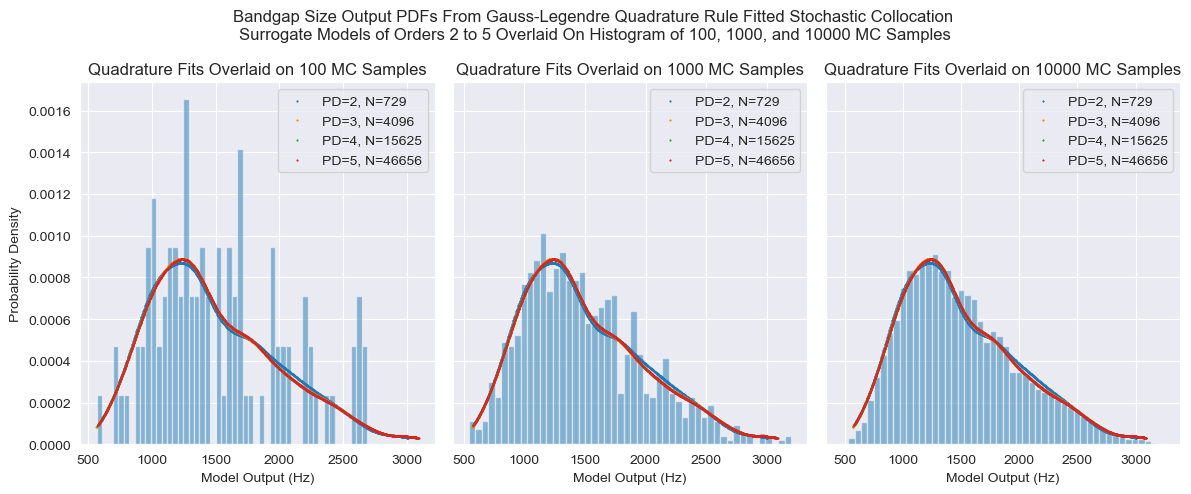

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))
axs[0].hist(bg_size_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_size_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5)

for d in degrees:
    plot_label = 'PD='+str(d)+', N='+str((d+1)**6)
    axs[0].scatter(np.linspace(np.min(surrogate_outputs[d]), np.max(surrogate_outputs[d]), 1000), surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(surrogate_outputs[d]), np.max(surrogate_outputs[d]), 1000), surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(surrogate_outputs[d]), np.max(surrogate_outputs[d]), 1000), surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('Quadrature Fits Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('Quadrature Fits Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('Quadrature Fits Overlaid on 10000 MC Samples')

title_str = 'Bandgap Size Output PDFs From Gauss-Legendre Quadrature Rule Fitted Stochastic Collocation \nSurrogate Models of Orders 2 to 5 Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Quadrature fits on bandgap top

In [13]:
### FIT SURROGATE MODELS - QUADRATURE RULE - BANDGAP TOP ###
q_surrogates_bgt = {}
for degree in degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist,
        normed=True
    )
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=quadrature_nodes[degree],
        weights=quadrature_weights[degree],
        solves=bg_top_sample_sets[degree]
    )
    q_surrogates_bgt[degree] = polynomial_approximation

In [14]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_bgt = 1000
joint_test_bgt = joint_dist.sample(N_test_bgt)
print(joint_test_bgt.shape)
#print(joint_test_bgt[0])
surrogate_outputs_bgt = {}
surrogate_kdes_bgt = {}
surrogate_pdf_bgt = {}
for degree in degrees:
    surrogate_model = q_surrogates_bgt[degree]
    #print(type(surrogate_model))
    #print(surrogate_model)
    #surrogate_outputs_bgt[degree] = surrogate_model.__call__(joint_test_bgt).astype(float)
    surrogate_outputs_bgt[degree] = surrogate_model(
        q0=joint_test_bgt[0,:], q1=joint_test_bgt[1,:],
        q2=joint_test_bgt[2,:], q3=joint_test_bgt[3,:],
        q4=joint_test_bgt[4,:], q5=joint_test_bgt[5,:])
    #print(surrogate_outputs_bgt[degree])
    surrogate_kdes_bgt[degree] = gaussian_kde(surrogate_outputs_bgt[degree])
    surrogate_pdf_bgt[degree] = surrogate_kdes_bgt[degree](np.linspace(np.min(surrogate_outputs_bgt[degree]), np.max(surrogate_outputs_bgt[degree]), 1000))

(6, 1000)


Text(0.5, 0.98, 'Bandgap Top Output PDFs From Gauss-Legendre Quadrature Rule Fitted Stochastic Collocation \nSurrogate Models of Orders 2 to 5 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

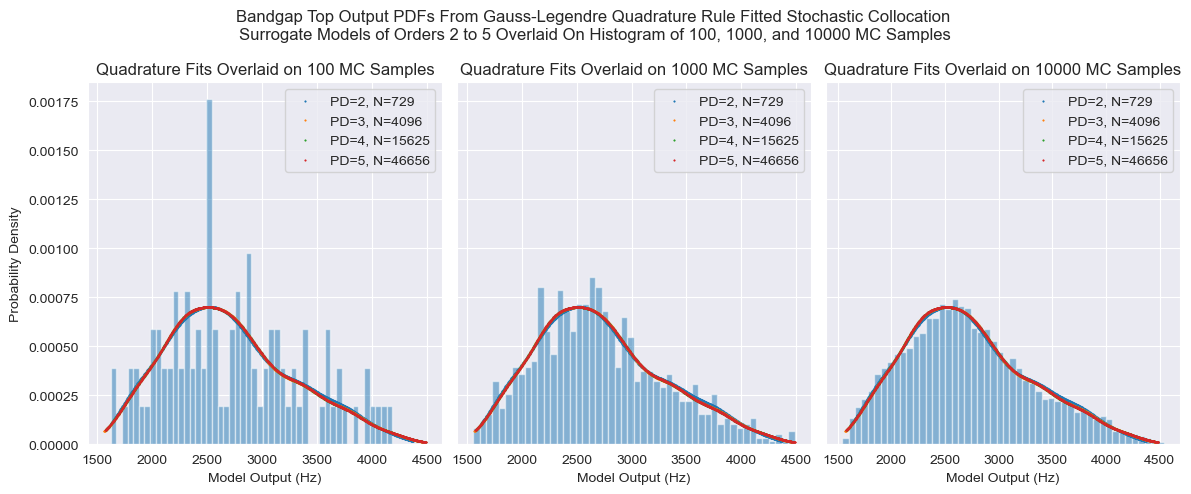

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))
axs[0].hist(bg_top_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_top_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_top_MC_sets[10000], bins=50, density=True, alpha=0.5)

for d in degrees:
    plot_label = 'PD='+str(d)+', N='+str((d+1)**6)
    axs[0].scatter(np.linspace(np.min(surrogate_outputs_bgt[d]), np.max(surrogate_outputs_bgt[d]), 1000), surrogate_pdf_bgt[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(surrogate_outputs_bgt[d]), np.max(surrogate_outputs_bgt[d]), 1000), surrogate_pdf_bgt[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(surrogate_outputs_bgt[d]), np.max(surrogate_outputs_bgt[d]), 1000), surrogate_pdf_bgt[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('Quadrature Fits Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('Quadrature Fits Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('Quadrature Fits Overlaid on 10000 MC Samples')

title_str = 'Bandgap Top Output PDFs From Gauss-Legendre Quadrature Rule Fitted Stochastic Collocation \nSurrogate Models of Orders 2 to 5 Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Quadrature fits on bandgap bottom

In [16]:
### FIT SURROGATE MODELS - QUADRATURE RULE - BANDGAP BOTTOM ###
q_surrogates_bgb = {}
for degree in degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist,
        normed=True
    )
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=quadrature_nodes[degree],
        weights=quadrature_weights[degree],
        solves=bg_bottom_sample_sets[degree]
    )
    q_surrogates_bgb[degree] = polynomial_approximation

In [17]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_bgb = 1000
joint_test_bgb = joint_dist.sample(N_test_bgb)
print(joint_test_bgb.shape)
#print(joint_test_bgb[0])
surrogate_outputs_bgb = {}
surrogate_kdes_bgb = {}
surrogate_pdf_bgb = {}
for degree in degrees:
    surrogate_model = q_surrogates_bgb[degree]
    #print(type(surrogate_model))
    #print(surrogate_model)
    #surrogate_outputs_bgb[degree] = surrogate_model.__call__(joint_test_bgb).astype(float)
    surrogate_outputs_bgb[degree] = surrogate_model(
        q0=joint_test_bgb[0,:], q1=joint_test_bgb[1,:],
        q2=joint_test_bgb[2,:], q3=joint_test_bgb[3,:],
        q4=joint_test_bgb[4,:], q5=joint_test_bgb[5,:])
    #print(surrogate_outputs_bgb[degree])
    surrogate_kdes_bgb[degree] = gaussian_kde(surrogate_outputs_bgb[degree])
    surrogate_pdf_bgb[degree] = surrogate_kdes_bgb[degree](np.linspace(np.min(surrogate_outputs_bgb[degree]), np.max(surrogate_outputs_bgb[degree]), 1000))

(6, 1000)


Text(0.5, 0.98, 'Bandgap Bottom Output PDFs From Gauss-Legendre Quadrature Rule Fitted Stochastic Collocation \nSurrogate Models of Orders 2 to 5 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

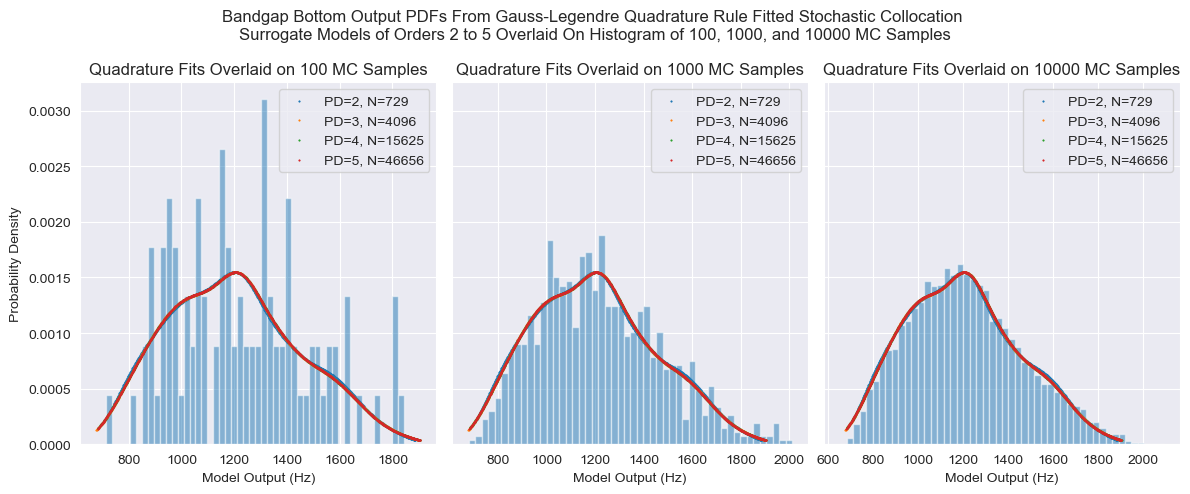

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))
axs[0].hist(bg_bottom_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_bottom_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_bottom_MC_sets[10000], bins=50, density=True, alpha=0.5)

for d in degrees:
    plot_label = 'PD='+str(d)+', N='+str((d+1)**6)
    axs[0].scatter(np.linspace(np.min(surrogate_outputs_bgb[d]), np.max(surrogate_outputs_bgb[d]), 1000), surrogate_pdf_bgb[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(surrogate_outputs_bgb[d]), np.max(surrogate_outputs_bgb[d]), 1000), surrogate_pdf_bgb[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(surrogate_outputs_bgb[d]), np.max(surrogate_outputs_bgb[d]), 1000), surrogate_pdf_bgb[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('Quadrature Fits Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('Quadrature Fits Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('Quadrature Fits Overlaid on 10000 MC Samples')

title_str = 'Bandgap Bottom Output PDFs From Gauss-Legendre Quadrature Rule Fitted Stochastic Collocation \nSurrogate Models of Orders 2 to 5 Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Quadrature fits on bandgap center

In [19]:
### FIT SURROGATE MODELS - QUADRATURE RULE - BANDGAP CENTER ###

In [20]:
q_surrogates_bgc = {}

for degree in degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist,
        normed=True
    )
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=quadrature_nodes[degree],
        weights=quadrature_weights[degree],
        solves=bg_center_sample_sets[degree]
    )
    q_surrogates_bgc[degree] = polynomial_approximation

In [21]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_bgc = 1000
joint_test_bgc = joint_dist.sample(N_test_bgc)
print(joint_test_bgc.shape)
#print(joint_test_bgc[0])
surrogate_outputs_bgc = {}
surrogate_kdes_bgc = {}
surrogate_pdf_bgc = {}
for degree in degrees:
    surrogate_model = q_surrogates_bgc[degree]
    #print(type(surrogate_model))
    #print(surrogate_model)
    #surrogate_outputs_bgc[degree] = surrogate_model.__call__(joint_test_bgc).astype(float)
    surrogate_outputs_bgc[degree] = surrogate_model(
        q0=joint_test_bgc[0,:], q1=joint_test_bgc[1,:],
        q2=joint_test_bgc[2,:], q3=joint_test_bgc[3,:],
        q4=joint_test_bgc[4,:], q5=joint_test_bgc[5,:])
    #print(surrogate_outputs_bgc[degree])
    surrogate_kdes_bgc[degree] = gaussian_kde(surrogate_outputs_bgc[degree])
    surrogate_pdf_bgc[degree] = surrogate_kdes_bgc[degree](np.linspace(np.min(surrogate_outputs_bgc[degree]), np.max(surrogate_outputs_bgc[degree]), 1000))

(6, 1000)


Text(0.5, 0.98, 'Bandgap Center Output PDFs From Gauss-Legendre Quadrature Rule Fitted Stochastic Collocation \nSurrogate Models of Orders 2 to 5 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

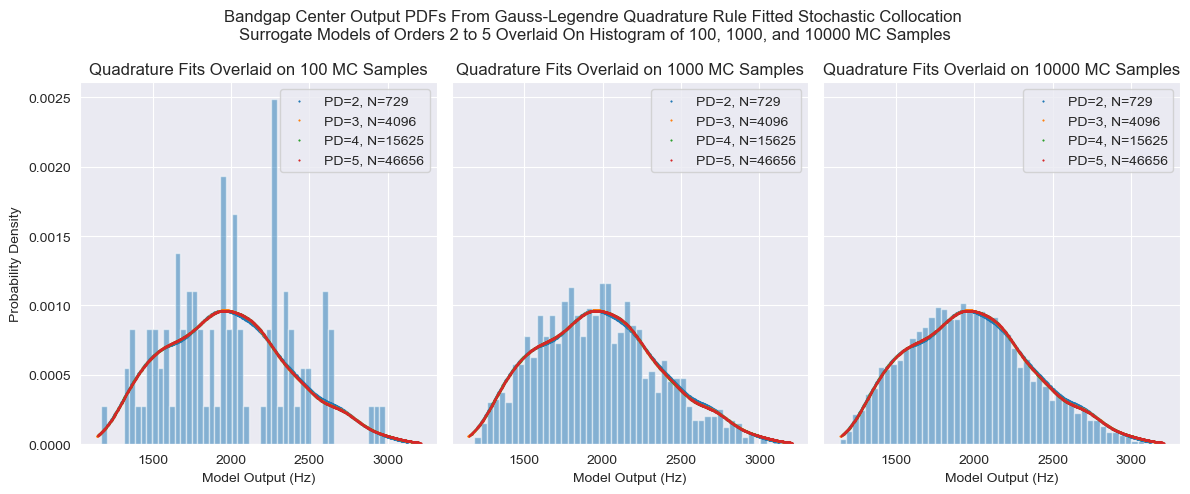

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))
axs[0].hist(bg_center_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_center_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_center_MC_sets[10000], bins=50, density=True, alpha=0.5)

for d in degrees:
    plot_label = 'PD='+str(d)+', N='+str((d+1)**6)
    axs[0].scatter(np.linspace(np.min(surrogate_outputs_bgc[d]), np.max(surrogate_outputs_bgc[d]), 1000), surrogate_pdf_bgc[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(surrogate_outputs_bgc[d]), np.max(surrogate_outputs_bgc[d]), 1000), surrogate_pdf_bgc[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(surrogate_outputs_bgc[d]), np.max(surrogate_outputs_bgc[d]), 1000), surrogate_pdf_bgc[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('Quadrature Fits Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('Quadrature Fits Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('Quadrature Fits Overlaid on 10000 MC Samples')

title_str = 'Bandgap Center Output PDFs From Gauss-Legendre Quadrature Rule Fitted Stochastic Collocation \nSurrogate Models of Orders 2 to 5 Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Alternative Graphs

Text(0.5, 0.98, "Histograms of 100, 1000, & 10000 MC Samples' Computed Bandgap Top, Bottom, and Center Locations")

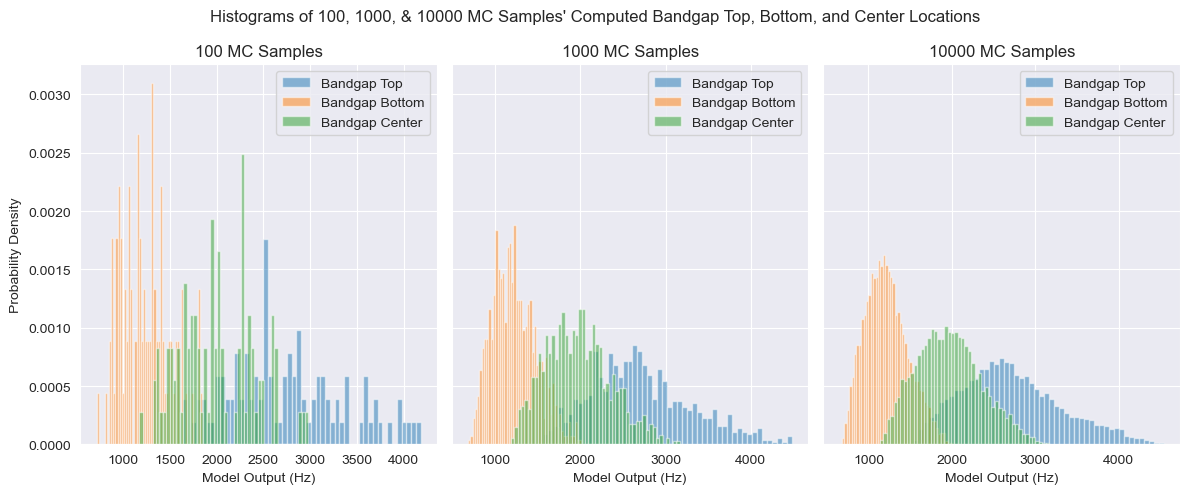

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))
axs[0].hist(bg_top_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[1].hist(bg_top_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[2].hist(bg_top_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[0].hist(bg_bottom_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[1].hist(bg_bottom_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[2].hist(bg_bottom_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[0].hist(bg_center_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Center')
axs[1].hist(bg_center_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Center')
axs[2].hist(bg_center_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Center')
# axs[0].hist(bg_size_MC_sets[100], bins=50, density=True, alpha=0.5)
# axs[1].hist(bg_size_MC_sets[1000], bins=50, density=True, alpha=0.5)
# axs[2].hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('10000 MC Samples')

title_str = 'Histograms of 100, 1000, & 10000 MC Samples\' Computed Bandgap Top, Bottom, and Center Locations'
fig.suptitle(title_str)


Text(0.5, 0.98, "Histograms of 100, 1000, & 10000 MC Samples' Computed Bandgap Top and Bottom Locations and Bandgap Size")

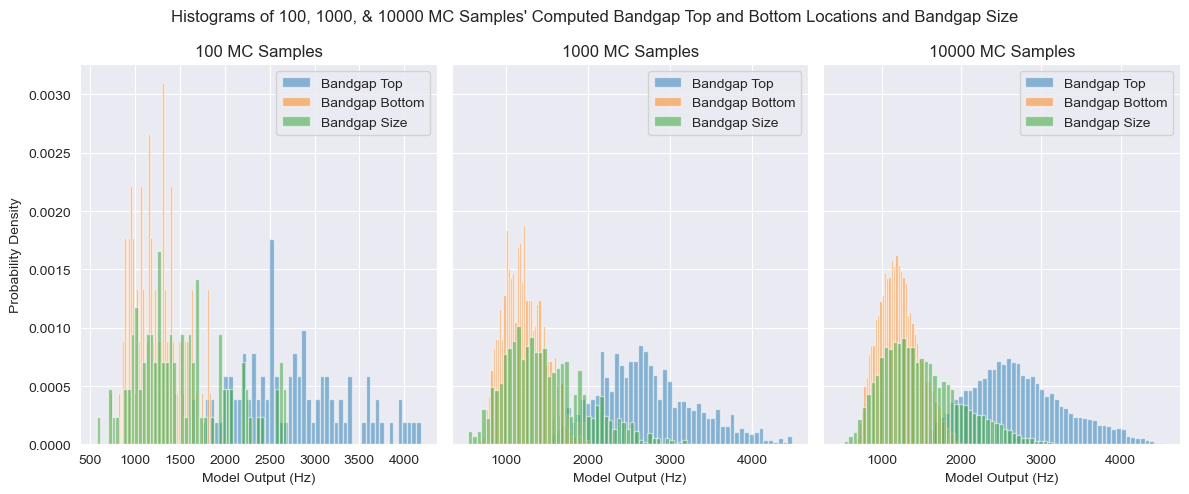

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))
axs[0].hist(bg_top_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[1].hist(bg_top_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[2].hist(bg_top_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[0].hist(bg_bottom_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[1].hist(bg_bottom_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[2].hist(bg_bottom_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[0].hist(bg_size_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Size')
axs[1].hist(bg_size_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Size')
axs[2].hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Size')

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('10000 MC Samples')

title_str = 'Histograms of 100, 1000, & 10000 MC Samples\' Computed Bandgap Top and Bottom Locations and Bandgap Size'
fig.suptitle(title_str)

Text(0.5, 0.98, "Histograms of 100, 1000, & 10000 MC Samples' Computed Bandgap Top and Bottom Locations")

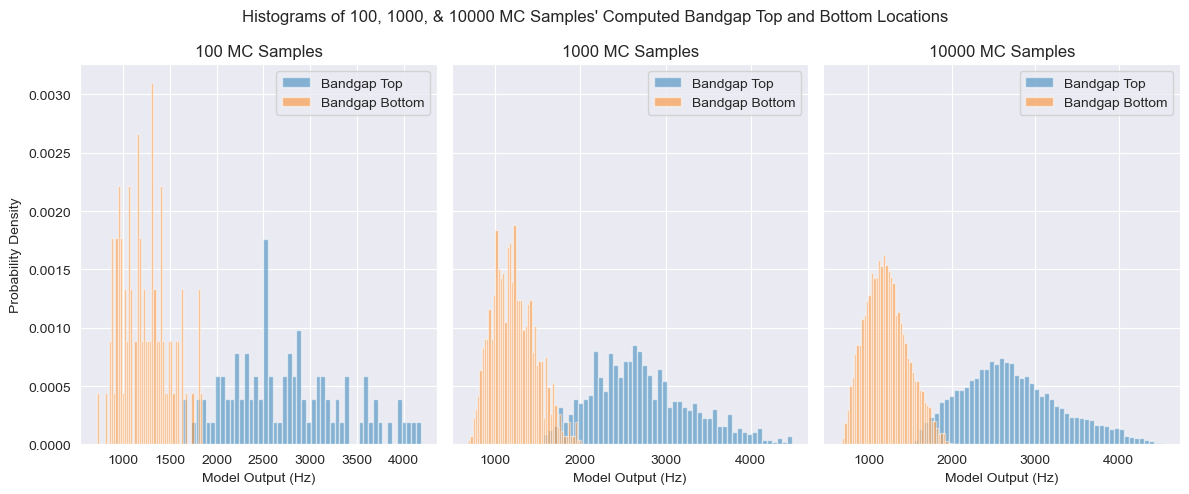

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))
axs[0].hist(bg_top_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[1].hist(bg_top_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[2].hist(bg_top_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[0].hist(bg_bottom_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[1].hist(bg_bottom_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[2].hist(bg_bottom_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('10000 MC Samples')

title_str = 'Histograms of 100, 1000, & 10000 MC Samples\' Computed Bandgap Top and Bottom Locations'
fig.suptitle(title_str)

Text(0.5, 0.98, 'Histograms of 100 MC Samples Of 6D Input Space')

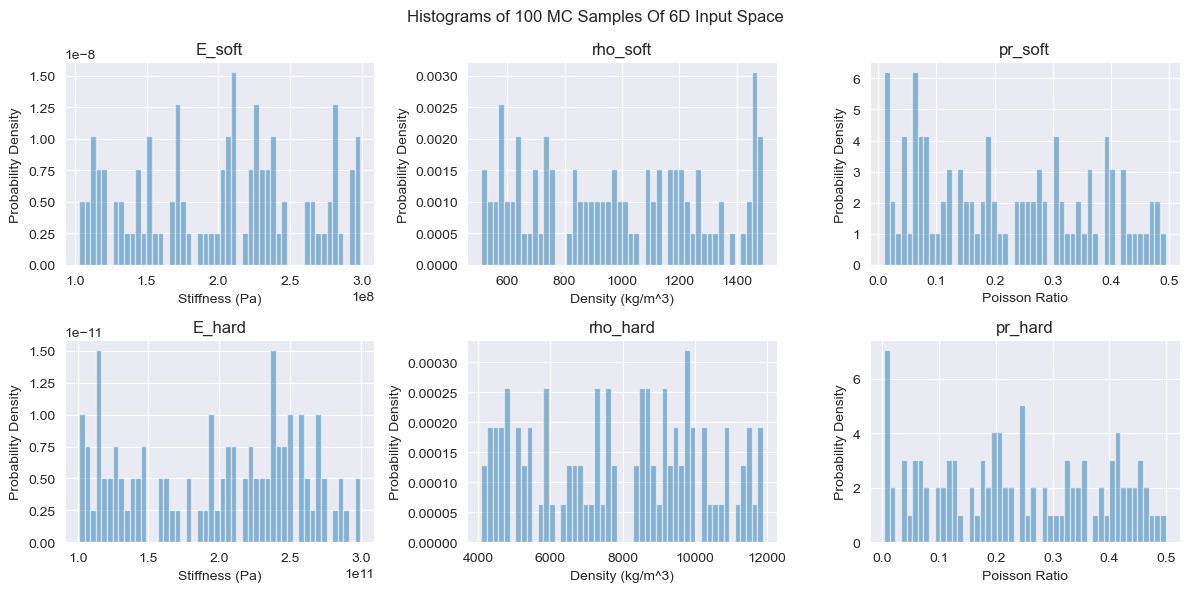

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(12,6))
axs[0,0].hist(E_soft_MC_sets[100].T, bins=50, density=True, alpha=0.5, label='E Soft')
axs[0,1].hist(rho_soft_MC_sets[100].T, bins=50, density=True, alpha=0.5, label='Rho Soft')
axs[0,2].hist(pr_soft_MC_sets[100].T, bins=50, density=True, alpha=0.5, label='Poisson Ratio Soft')
axs[1,0].hist(E_hard_MC_sets[100].T, bins=50, density=True, alpha=0.5, label='E Hard')
axs[1,1].hist(rho_hard_MC_sets[100].T, bins=50, density=True, alpha=0.5, label='Rho Hard')
axs[1,2].hist(pr_hard_MC_sets[100].T, bins=50, density=True, alpha=0.5, label='Poisson Ratio Hard')

axs[0,0].set_xlabel("Stiffness (Pa)")
axs[0,0].set_ylabel("Probability Density")
axs[0,0].set_title('E_soft')

axs[0,1].set_xlabel("Density (kg/m^3)")
axs[0,1].set_ylabel("Probability Density")
axs[0,1].set_title('rho_soft')

axs[0,2].set_xlabel("Poisson Ratio")
axs[0,2].set_ylabel("Probability Density")
axs[0,2].set_title('pr_soft')

axs[1,0].set_xlabel("Stiffness (Pa)")
axs[1,0].set_ylabel("Probability Density")
axs[1,0].set_title('E_hard')

axs[1,1].set_xlabel("Density (kg/m^3)")
axs[1,1].set_ylabel("Probability Density")
axs[1,1].set_title('rho_hard')

axs[1,2].set_xlabel("Poisson Ratio")
axs[1,2].set_ylabel("Probability Density")
axs[1,2].set_title('pr_hard')

title_str = 'Histograms of 100 MC Samples Of 6D Input Space'
fig.suptitle(title_str)

Text(0.5, 0.98, 'Histograms of 1000 MC Samples Of 6D Input Space')

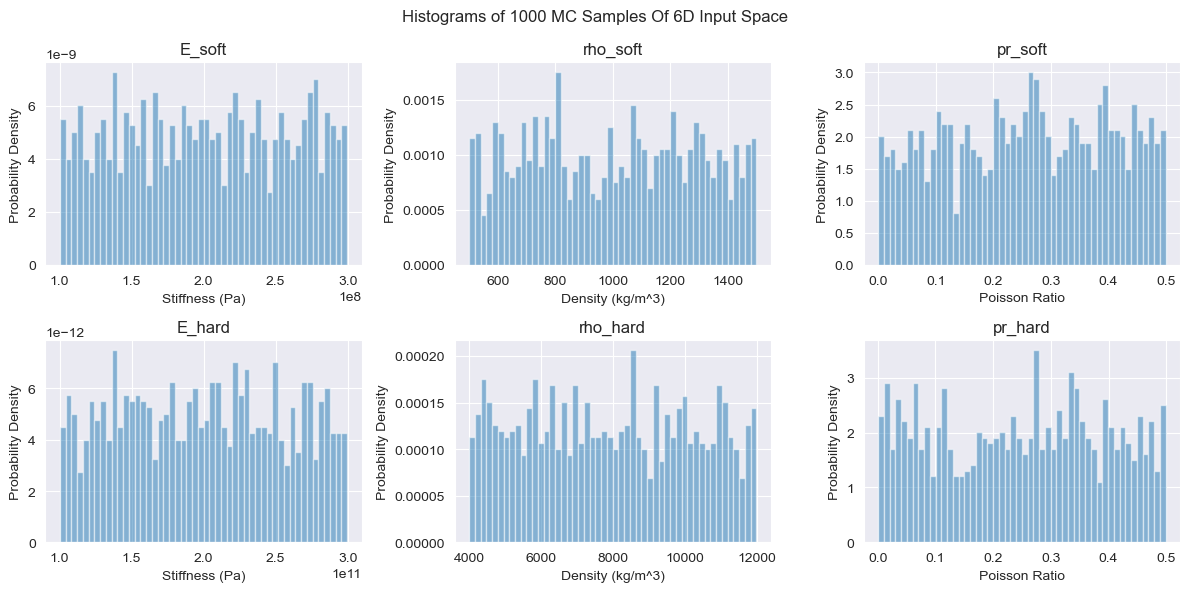

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(12,6))
axs[0,0].hist(E_soft_MC_sets[1000].T, bins=50, density=True, alpha=0.5, label='E Soft')
axs[0,1].hist(rho_soft_MC_sets[1000].T, bins=50, density=True, alpha=0.5, label='Rho Soft')
axs[0,2].hist(pr_soft_MC_sets[1000].T, bins=50, density=True, alpha=0.5, label='Poisson Ratio Soft')
axs[1,0].hist(E_hard_MC_sets[1000].T, bins=50, density=True, alpha=0.5, label='E Hard')
axs[1,1].hist(rho_hard_MC_sets[1000].T, bins=50, density=True, alpha=0.5, label='Rho Hard')
axs[1,2].hist(pr_hard_MC_sets[1000].T, bins=50, density=True, alpha=0.5, label='Poisson Ratio Hard')

axs[0,0].set_xlabel("Stiffness (Pa)")
axs[0,0].set_ylabel("Probability Density")
axs[0,0].set_title('E_soft')

axs[0,1].set_xlabel("Density (kg/m^3)")
axs[0,1].set_ylabel("Probability Density")
axs[0,1].set_title('rho_soft')

axs[0,2].set_xlabel("Poisson Ratio")
axs[0,2].set_ylabel("Probability Density")
axs[0,2].set_title('pr_soft')

axs[1,0].set_xlabel("Stiffness (Pa)")
axs[1,0].set_ylabel("Probability Density")
axs[1,0].set_title('E_hard')

axs[1,1].set_xlabel("Density (kg/m^3)")
axs[1,1].set_ylabel("Probability Density")
axs[1,1].set_title('rho_hard')

axs[1,2].set_xlabel("Poisson Ratio")
axs[1,2].set_ylabel("Probability Density")
axs[1,2].set_title('pr_hard')

title_str = 'Histograms of 1000 MC Samples Of 6D Input Space'
fig.suptitle(title_str)

Text(0.5, 0.98, 'Histograms of 10000 MC Samples Of 6D Input Space')

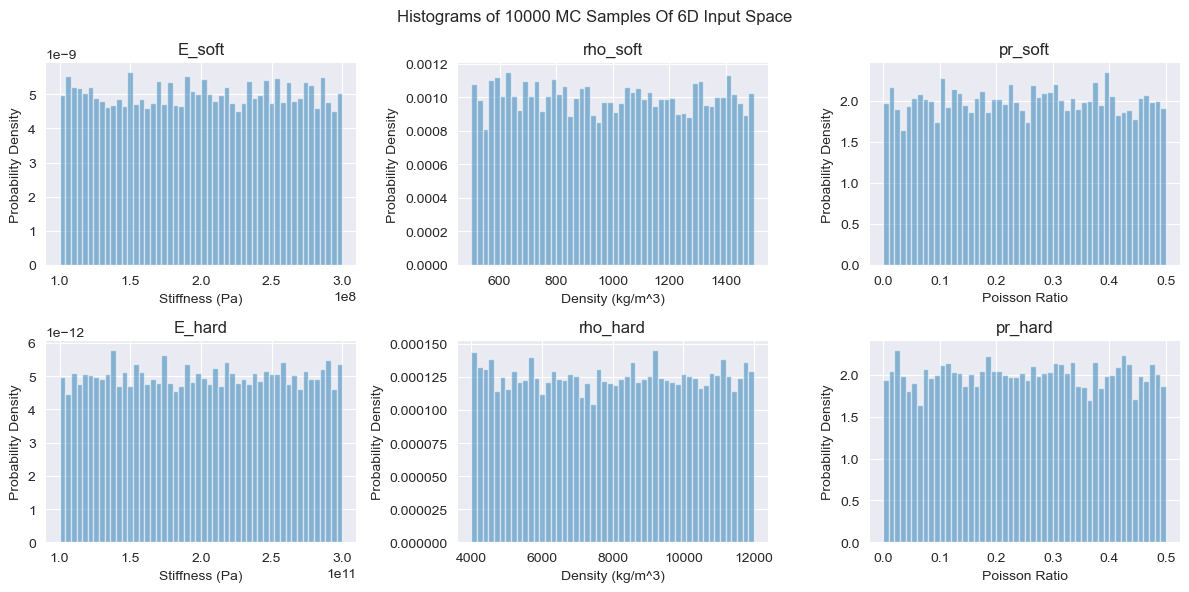

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(12,6))
axs[0,0].hist(E_soft_MC_sets[10000].T, bins=50, density=True, alpha=0.5, label='E Soft')
axs[0,1].hist(rho_soft_MC_sets[10000].T, bins=50, density=True, alpha=0.5, label='Rho Soft')
axs[0,2].hist(pr_soft_MC_sets[10000].T, bins=50, density=True, alpha=0.5, label='Poisson Ratio Soft')
axs[1,0].hist(E_hard_MC_sets[10000].T, bins=50, density=True, alpha=0.5, label='E Hard')
axs[1,1].hist(rho_hard_MC_sets[10000].T, bins=50, density=True, alpha=0.5, label='Rho Hard')
axs[1,2].hist(pr_hard_MC_sets[10000].T, bins=50, density=True, alpha=0.5, label='Poisson Ratio Hard')

axs[0,0].set_xlabel("Stiffness (Pa)")
axs[0,0].set_ylabel("Probability Density")
axs[0,0].set_title('E_soft')

axs[0,1].set_xlabel("Density (kg/m^3)")
axs[0,1].set_ylabel("Probability Density")
axs[0,1].set_title('rho_soft')

axs[0,2].set_xlabel("Poisson Ratio")
axs[0,2].set_ylabel("Probability Density")
axs[0,2].set_title('pr_soft')

axs[1,0].set_xlabel("Stiffness (Pa)")
axs[1,0].set_ylabel("Probability Density")
axs[1,0].set_title('E_hard')

axs[1,1].set_xlabel("Density (kg/m^3)")
axs[1,1].set_ylabel("Probability Density")
axs[1,1].set_title('rho_hard')

axs[1,2].set_xlabel("Poisson Ratio")
axs[1,2].set_ylabel("Probability Density")
axs[1,2].set_title('pr_hard')

title_str = 'Histograms of 10000 MC Samples Of 6D Input Space'
fig.suptitle(title_str)

Stochastic Collocation - MC Regression - Bandgap Size

In [29]:
MC_inputs = {}
for n in set_N:
    MC_inputs[n] = np.vstack((
        E_soft_MC_sets[n],
        E_hard_MC_sets[n],
        rho_soft_MC_sets[n],
        rho_hard_MC_sets[n],
        pr_soft_MC_sets[n],
        pr_hard_MC_sets[n]
    ))

MC_degrees = [2,3]

In [30]:
### FIT SURROGATE MODELS - MONTE CARLO REGRESSION ###
r_surrogates = {}
for degree in MC_degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist,
        normed=True
    )
    # print(fit_input.shape)
    # print(bg_size_MC_sets[100].shape)
    polynomial_approximation = cp.fit_regression(
        polynomials=polynomial_basis,
        abscissas=MC_inputs[100],
        evals=bg_size_MC_sets[100],
    )
    r_surrogates[degree] = polynomial_approximation

In [31]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_mc = 1000
joint_test_mc = joint_dist.sample(N_test_mc)
#print(joint_test_mc.shape)
#print(joint_test_mc[0])
mc_surrogate_outputs = {}
mc_surrogate_kdes = {}
mc_surrogate_pdf = {}
for degree in MC_degrees:
    mc_surrogate_model = r_surrogates[degree]
    #print(type(mc_surrogate_model))
    #print(mc_surrogate_model)
    mc_surrogate_outputs[degree] = mc_surrogate_model(
        q0=joint_test_mc[0,:], q1=joint_test_mc[1,:],
        q2=joint_test_mc[2,:], q3=joint_test_mc[3,:],
        q4=joint_test_mc[4,:], q5=joint_test_mc[5,:])
    #print(mc_surrogate_outputs[degree])
    mc_surrogate_kdes[degree] = gaussian_kde(mc_surrogate_outputs[degree])
    mc_surrogate_pdf[degree] = mc_surrogate_kdes[degree](np.linspace(np.min(mc_surrogate_outputs[degree]), np.max(mc_surrogate_outputs[degree]), 1000))

Text(0.5, 0.98, 'Bandgap Size Output PDFs From 100 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 2 & 3 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

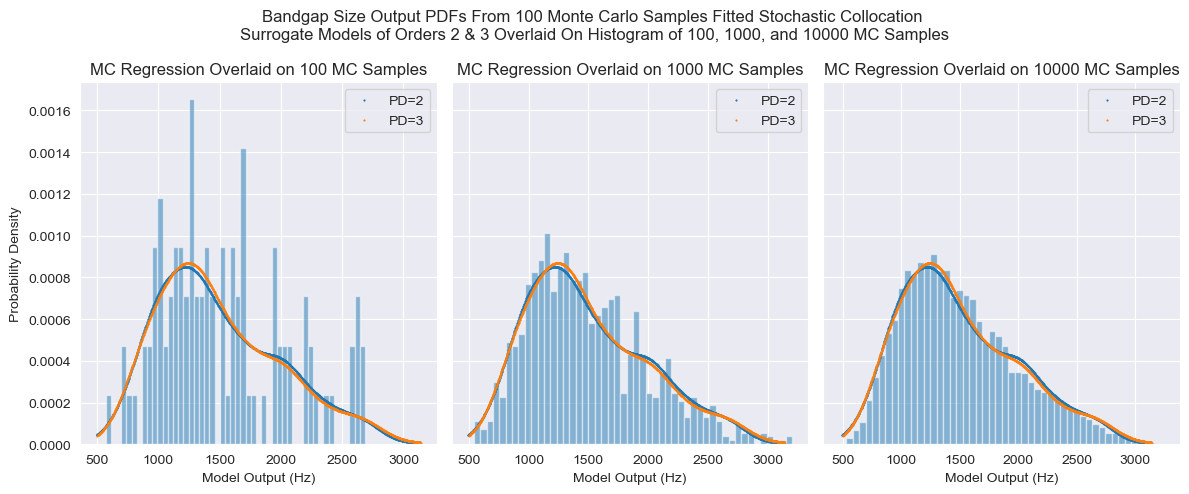

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))
axs[0].hist(bg_size_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_size_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5)

for d in MC_degrees:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[d]), np.max(mc_surrogate_outputs[d]), 1000), mc_surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[d]), np.max(mc_surrogate_outputs[d]), 1000), mc_surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[d]), np.max(mc_surrogate_outputs[d]), 1000), mc_surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid on 10000 MC Samples')

title_str = 'Bandgap Size Output PDFs From 100 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 2 & 3 Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Stochastic Collocation - MC Regression - Bandgap Top

In [33]:
### FIT SURROGATE MODELS - MONTE CARLO REGRESSION ###
r_surrogates_bgt = {}
for degree in MC_degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist,
        normed=True
    )
    # print(fit_input.shape)
    # print(bg_size_MC_sets[100].shape)
    polynomial_approximation = cp.fit_regression(
        polynomials=polynomial_basis,
        abscissas=MC_inputs[100],
        evals=bg_top_MC_sets[100],
    )
    r_surrogates_bgt[degree] = polynomial_approximation

In [34]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_mc_bgt = 1000
joint_test_mc_bgt = joint_dist.sample(N_test_mc_bgt)
#print(joint_test_mc_bgt.shape)
#print(joint_test_mc_bgt[0])
mc_surrogate_outputs_bgt = {}
mc_surrogate_kdes_bgt = {}
mc_surrogate_pdf_bgt = {}
for degree in MC_degrees:
    mc_surrogate_model = r_surrogates_bgt[degree]
    #print(type(mc_surrogate_model))
    #print(mc_surrogate_model)
    mc_surrogate_outputs_bgt[degree] = mc_surrogate_model(
        q0=joint_test_mc_bgt[0,:], q1=joint_test_mc_bgt[1,:],
        q2=joint_test_mc_bgt[2,:], q3=joint_test_mc_bgt[3,:],
        q4=joint_test_mc_bgt[4,:], q5=joint_test_mc_bgt[5,:])
    #print(mc_surrogate_outputs_bgt[degree])
    mc_surrogate_kdes_bgt[degree] = gaussian_kde(mc_surrogate_outputs_bgt[degree])
    mc_surrogate_pdf_bgt[degree] = mc_surrogate_kdes_bgt[degree](np.linspace(np.min(mc_surrogate_outputs_bgt[degree]), np.max(mc_surrogate_outputs_bgt[degree]), 1000))

Text(0.5, 0.98, 'Bandgap Top Output PDFs From 100 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 2 & 3 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

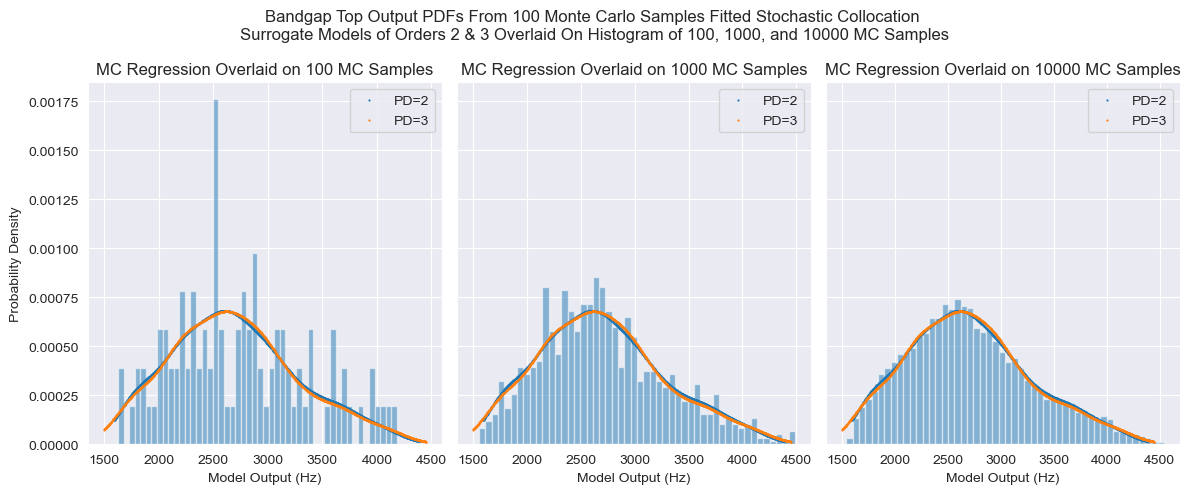

In [35]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))
axs[0].hist(bg_top_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_top_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_top_MC_sets[10000], bins=50, density=True, alpha=0.5)

for d in MC_degrees:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs_bgt[d]), np.max(mc_surrogate_outputs_bgt[d]), 1000), mc_surrogate_pdf_bgt[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs_bgt[d]), np.max(mc_surrogate_outputs_bgt[d]), 1000), mc_surrogate_pdf_bgt[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs_bgt[d]), np.max(mc_surrogate_outputs_bgt[d]), 1000), mc_surrogate_pdf_bgt[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid on 10000 MC Samples')

title_str = 'Bandgap Top Output PDFs From 100 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 2 & 3 Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Stochastic Collocation - MC Regression - Bandgap Bottom


In [36]:
### FIT SURROGATE MODELS - MONTE CARLO REGRESSION ###
r_surrogates_bgb = {}
for degree in MC_degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist,
        normed=True
    )
    # print(fit_input.shape)
    # print(bg_size_MC_sets[100].shape)
    polynomial_approximation = cp.fit_regression(
        polynomials=polynomial_basis,
        abscissas=MC_inputs[100],
        evals=bg_bottom_MC_sets[100],
    )
    r_surrogates_bgb[degree] = polynomial_approximation

In [37]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_mc_bgb = 1000
joint_test_mc_bgb = joint_dist.sample(N_test_mc_bgb)
#print(joint_test_mc_bgb.shape)
#print(joint_test_mc_bgb[0])
mc_surrogate_outputs_bgb = {}
mc_surrogate_kdes_bgb = {}
mc_surrogate_pdf_bgb = {}
for degree in MC_degrees:
    mc_surrogate_model = r_surrogates_bgb[degree]
    #print(type(mc_surrogate_model))
    #print(mc_surrogate_model)
    mc_surrogate_outputs_bgb[degree] = mc_surrogate_model(
        q0=joint_test_mc_bgb[0,:], q1=joint_test_mc_bgb[1,:],
        q2=joint_test_mc_bgb[2,:], q3=joint_test_mc_bgb[3,:],
        q4=joint_test_mc_bgb[4,:], q5=joint_test_mc_bgb[5,:])
    #print(mc_surrogate_outputs_bgb[degree])
    mc_surrogate_kdes_bgb[degree] = gaussian_kde(mc_surrogate_outputs_bgb[degree])
    mc_surrogate_pdf_bgb[degree] = mc_surrogate_kdes_bgb[degree](np.linspace(np.min(mc_surrogate_outputs_bgb[degree]), np.max(mc_surrogate_outputs_bgb[degree]), 1000))

Text(0.5, 0.98, 'Bandgap Bottom Output PDFs From 100 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 2 & 3 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

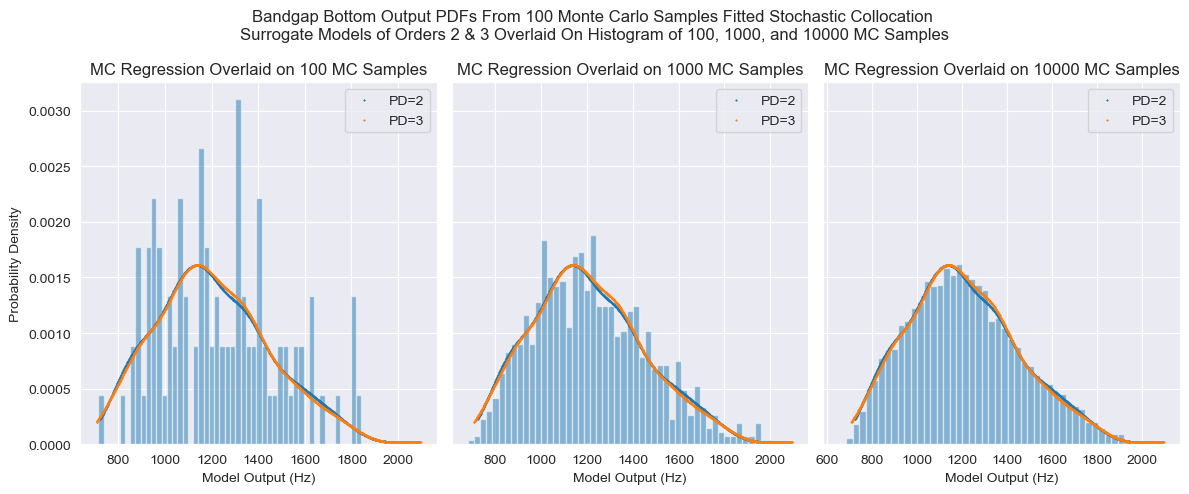

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))
axs[0].hist(bg_bottom_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_bottom_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_bottom_MC_sets[10000], bins=50, density=True, alpha=0.5)

for d in MC_degrees:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs_bgb[d]), np.max(mc_surrogate_outputs_bgb[d]), 1000), mc_surrogate_pdf_bgb[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs_bgb[d]), np.max(mc_surrogate_outputs_bgb[d]), 1000), mc_surrogate_pdf_bgb[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs_bgb[d]), np.max(mc_surrogate_outputs_bgb[d]), 1000), mc_surrogate_pdf_bgb[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid on 10000 MC Samples')

title_str = 'Bandgap Bottom Output PDFs From 100 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 2 & 3 Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Stochastic Collocation - MC Regression - Bandgap Center

In [39]:
### FIT SURROGATE MODELS - MONTE CARLO REGRESSION ###
r_surrogates_bgc = {}
for degree in MC_degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist,
        normed=True
    )
    # print(fit_input.shape)
    # print(bg_size_MC_sets[100].shape)
    polynomial_approximation = cp.fit_regression(
        polynomials=polynomial_basis,
        abscissas=MC_inputs[100],
        evals=bg_center_MC_sets[100],
    )
    r_surrogates_bgc[degree] = polynomial_approximation

In [40]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_mc_bgc = 1000
joint_test_mc_bgc = joint_dist.sample(N_test_mc_bgc)
#print(joint_test_mc_bgc.shape)
#print(joint_test_mc_bgc[0])
mc_surrogate_outputs_bgc = {}
mc_surrogate_kdes_bgc = {}
mc_surrogate_pdf_bgc = {}
for degree in MC_degrees:
    mc_surrogate_model = r_surrogates_bgc[degree]
    #print(type(mc_surrogate_model))
    #print(mc_surrogate_model)
    mc_surrogate_outputs_bgc[degree] = mc_surrogate_model(
        q0=joint_test_mc_bgc[0,:], q1=joint_test_mc_bgc[1,:],
        q2=joint_test_mc_bgc[2,:], q3=joint_test_mc_bgc[3,:],
        q4=joint_test_mc_bgc[4,:], q5=joint_test_mc_bgc[5,:])
    #print(mc_surrogate_outputs_bgc[degree])
    mc_surrogate_kdes_bgc[degree] = gaussian_kde(mc_surrogate_outputs_bgc[degree])
    mc_surrogate_pdf_bgc[degree] = mc_surrogate_kdes_bgc[degree](np.linspace(np.min(mc_surrogate_outputs_bgc[degree]), np.max(mc_surrogate_outputs_bgc[degree]), 1000))

Text(0.5, 0.98, 'Bandgap Center Output PDFs From 100 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 2 & 3 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

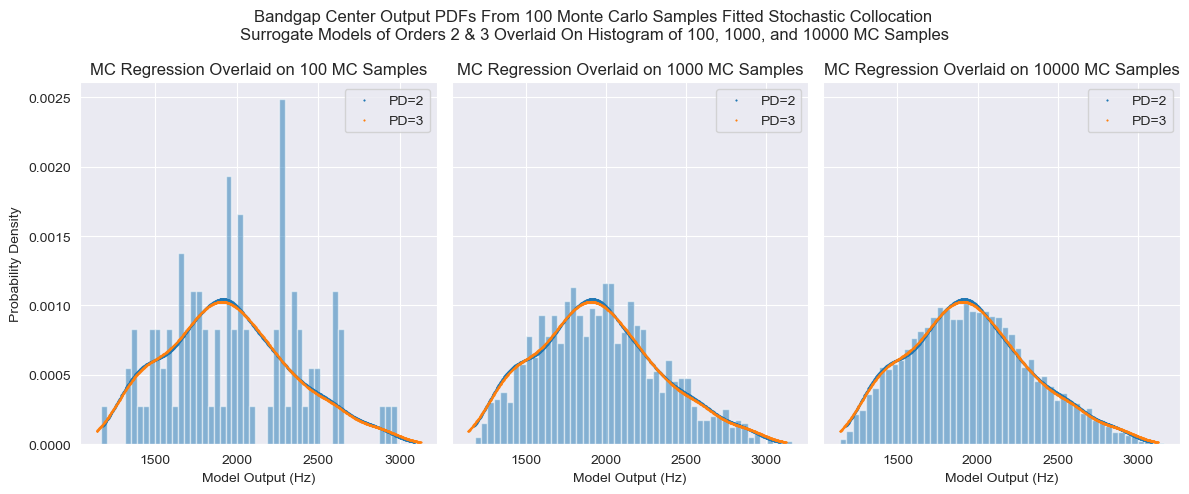

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))
axs[0].hist(bg_center_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_center_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_center_MC_sets[10000], bins=50, density=True, alpha=0.5)

for d in MC_degrees:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs_bgc[d]), np.max(mc_surrogate_outputs_bgc[d]), 1000), mc_surrogate_pdf_bgc[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs_bgc[d]), np.max(mc_surrogate_outputs_bgc[d]), 1000), mc_surrogate_pdf_bgc[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs_bgc[d]), np.max(mc_surrogate_outputs_bgc[d]), 1000), mc_surrogate_pdf_bgc[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid on 10000 MC Samples')

title_str = 'Bandgap Center Output PDFs From 100 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 2 & 3 Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Individual Input Variations - Bandgap Size - E_soft

In [42]:
N_1d_mc_E_soft = [100, 1000, 10000]
sample_1d_mc_E_soft_sets = {}
for N in N_1d_mc_E_soft:
    sample_1d_mc_E_soft = E_soft_dist.sample(N)
    sample_1d_mc_E_soft_sets[N] = sample_1d_mc_E_soft
    savemat('E_soft_dist_mc'+str(N)+'.mat',{'mc_'+str(N)+'_inputs':sample_1d_mc_E_soft})

In [58]:
E_soft_1d_mc_sample_sets = {}
bg_size_1d_E_soft_mc_sample_sets = {}
bg_top_1d_E_soft_mc_sample_sets = {}
bg_bottom_1d_E_soft_mc_sample_sets = {}
bg_center_1d_E_soft_mc_sample_sets = {}

for N in N_1d_mc_E_soft:
    folder_name = 'mc_E_soft'
    file_suffix = '_uniform_mc'+str(N)+'.mat'
    E_soft_file = loadmat(folder_name+'/E_soft'+file_suffix)
    bg_size_1d_E_soft_file = loadmat(folder_name+'/bg_size'+file_suffix)
    bg_top_1d_E_soft_file = loadmat(folder_name+'/bg_top'+file_suffix)
    bg_bottom_1d_E_soft_file = loadmat(folder_name+'/bg_bottom'+file_suffix)

    E_soft_sample_sets[N] = E_soft_file['E_soft'][:]
    bg_size_1d_E_soft_mc_sample_sets[N] = bg_size_1d_E_soft_file['bg_size'][:]
    bg_top_1d_E_soft_mc_sample_sets[N] = bg_top_1d_E_soft_file['bg_top'][:]
    bg_bottom_1d_E_soft_mc_sample_sets[N] = bg_bottom_1d_E_soft_file['bg_bottom'][:]
    bg_center_1d_E_soft_mc_sample_sets[N] = (bg_top_1d_E_soft_mc_sample_sets[N] + bg_bottom_1d_E_soft_mc_sample_sets[N])/2

Text(0.5, 0.98, 'Histograms of 20, 100,& 500 MC Samples Of E_soft & Bandgap Size')

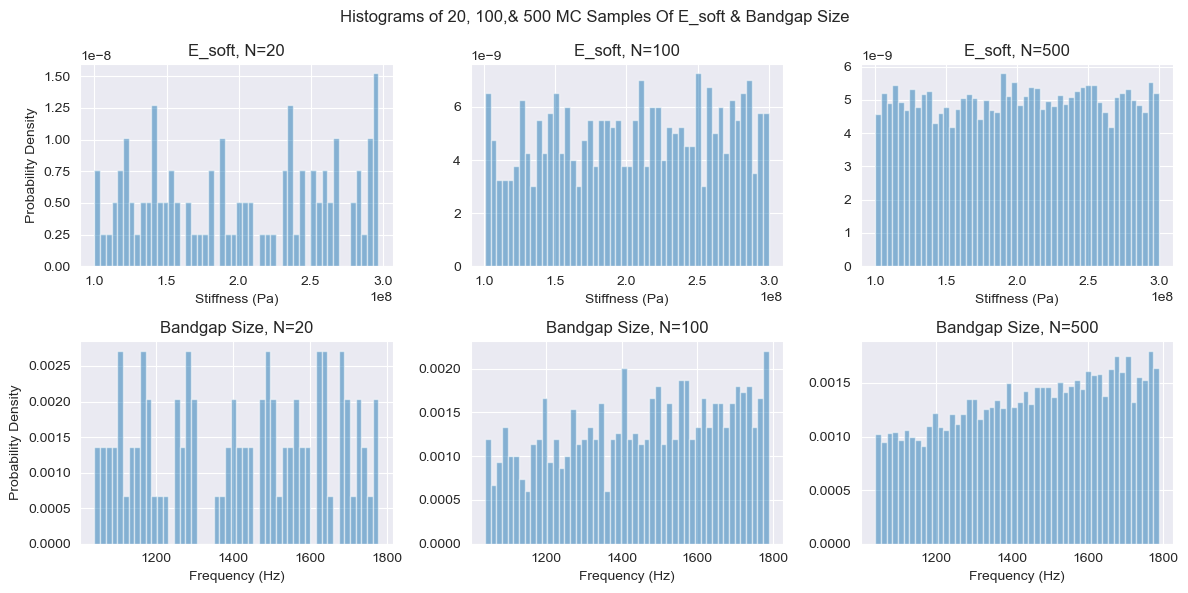

In [45]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharey=False, tight_layout=True, figsize=(12,6))
axs[0,0].hist(sample_1d_mc_E_soft_sets[100].T, bins=50, density=True, alpha=0.5)
axs[0,1].hist(sample_1d_mc_E_soft_sets[1000].T, bins=50, density=True, alpha=0.5)
axs[0,2].hist(sample_1d_mc_E_soft_sets[10000].T, bins=50, density=True, alpha=0.5)
axs[1,0].hist(bg_size_1d_E_soft_mc_sample_sets[100], bins=50, density=True, alpha=0.5)
axs[1,1].hist(bg_size_1d_E_soft_mc_sample_sets[1000], bins=50, density=True, alpha=0.5)
axs[1,2].hist(bg_size_1d_E_soft_mc_sample_sets[10000], bins=50, density=True, alpha=0.5)

axs[0,0].set_xlabel("Stiffness (Pa)")
axs[0,0].set_ylabel("Probability Density")
axs[0,0].set_title('E_soft, N=20')

axs[0,1].set_xlabel("Stiffness (Pa)")
#axs[0,1].set_ylabel("Probability Density")
axs[0,1].set_title('E_soft, N=100')

axs[0,2].set_xlabel("Stiffness (Pa)")
#axs[0,2].set_ylabel("Probability Density")
axs[0,2].set_title('E_soft, N=500')

axs[1,0].set_xlabel("Frequency (Hz)")
axs[1,0].set_ylabel("Probability Density")
axs[1,0].set_title('Bandgap Size, N=20')

axs[1,1].set_xlabel("Frequency (Hz)")
#axs[1,1].set_ylabel("Probability Density")
axs[1,1].set_title('Bandgap Size, N=100')

axs[1,2].set_xlabel("Frequency (Hz)")
#axs[1,2].set_ylabel("Probability Density")
axs[1,2].set_title('Bandgap Size, N=500')

title_str = 'Histograms of 20, 100,& 500 MC Samples Of E_soft & Bandgap Size'
fig.suptitle(title_str)

In [46]:
quadrature_1d_surrogates_E_soft = {}
quadrature_1d_nodes_E_soft = {}
quadrature_1d_weights_E_soft = {}
for d in degrees:
    nodes, weights = cp.generate_quadrature(d, E_soft_dist, rule='G')
    quadrature_1d_nodes_E_soft[d] = nodes
    quadrature_1d_weights_E_soft[d] = weights

for qd in quadrature_1d_nodes_E_soft:
    savemat('E_soft_dist_q_pd'+str(qd)+'.mat',{'pd_'+str(qd)+'_inputs':quadrature_1d_nodes_E_soft[qd]})

In [47]:
E_soft_sample_sets = {}
bg_size_1d_E_soft_sample_sets = {}
bg_top_1d_E_soft_sample_sets = {}
bg_bottom_1d_E_soft_sample_sets = {}
bg_center_1d_E_soft_sample_sets = {}

for d in degrees:
    folder_name = 'quad_E_soft'
    file_suffix = '_uniform_q_pd'+str(d)+'.mat'
    E_soft_file = loadmat(folder_name+'/E_soft'+file_suffix)
    bg_size_1d_E_soft_file = loadmat(folder_name+'/bg_size'+file_suffix)
    bg_top_1d_E_soft_file = loadmat(folder_name+'/bg_top'+file_suffix)
    bg_bottom_1d_E_soft_file = loadmat(folder_name+'/bg_bottom'+file_suffix)

    E_soft_sample_sets[d] = E_soft_file['E_soft'][:]
    bg_size_1d_E_soft_sample_sets[d] = bg_size_1d_E_soft_file['bg_size'][:]
    bg_top_1d_E_soft_sample_sets[d] = bg_top_1d_E_soft_file['bg_top'][:]
    bg_bottom_1d_E_soft_sample_sets[d] = bg_bottom_1d_E_soft_file['bg_bottom'][:]
    bg_center_1d_E_soft_sample_sets[d] = (bg_top_1d_E_soft_sample_sets[d] + bg_bottom_1d_E_soft_sample_sets[d])/2

In [48]:
q_1d_E_soft_surrogates_bgs = {}

for degree in degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=E_soft_dist,
        normed=True
    )
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=quadrature_1d_nodes_E_soft[degree],
        weights=quadrature_1d_weights_E_soft[degree],
        solves=bg_size_1d_E_soft_sample_sets[degree]
    )
    q_1d_E_soft_surrogates_bgs[degree] = polynomial_approximation

In [49]:
q_1d_E_soft_surrogates_bgc = {}

for degree in degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=E_soft_dist,
        normed=True
    )
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=quadrature_1d_nodes_E_soft[degree],
        weights=quadrature_1d_weights_E_soft[degree],
        solves=bg_center_1d_E_soft_sample_sets[degree]
    )
    q_1d_E_soft_surrogates_bgc[degree] = polynomial_approximation

In [54]:
N_test_E_soft = 1000
E_soft_test = E_soft_dist.sample(N_test_E_soft)
E_soft_surrogate_outputs_bgs = {}
E_soft_surrogate_kdes_bgs = {}
E_soft_surrogate_pdf_bgs = {}
E_soft_surrogate_outputs_bgc = {}
E_soft_surrogate_kdes_bgc = {}
E_soft_surrogate_pdf_bgc = {}

for degree in degrees:
    E_soft_surrogate_outputs_bgs[degree] = q_1d_E_soft_surrogates_bgs[d](q0=E_soft_test)
    #print(mc_surrogate_outputs_bgc[degree])
    E_soft_surrogate_kdes_bgs[degree] = gaussian_kde(E_soft_surrogate_outputs_bgs[degree])
    E_soft_surrogate_pdf_bgs[degree] = E_soft_surrogate_kdes_bgs[degree](np.linspace(np.min(E_soft_surrogate_outputs_bgs[degree]), np.max(E_soft_surrogate_outputs_bgs[degree]), 1000))

    E_soft_surrogate_outputs_bgc[degree] = q_1d_E_soft_surrogates_bgc[d](q0=E_soft_test)
    #print(mc_surrogate_outputs_bgc[degree])
    E_soft_surrogate_kdes_bgc[degree] = gaussian_kde(E_soft_surrogate_outputs_bgc[degree])
    E_soft_surrogate_pdf_bgc[degree] = E_soft_surrogate_kdes_bgc[degree](np.linspace(np.min(E_soft_surrogate_outputs_bgc[degree]), np.max(E_soft_surrogate_outputs_bgc[degree]), 1000))

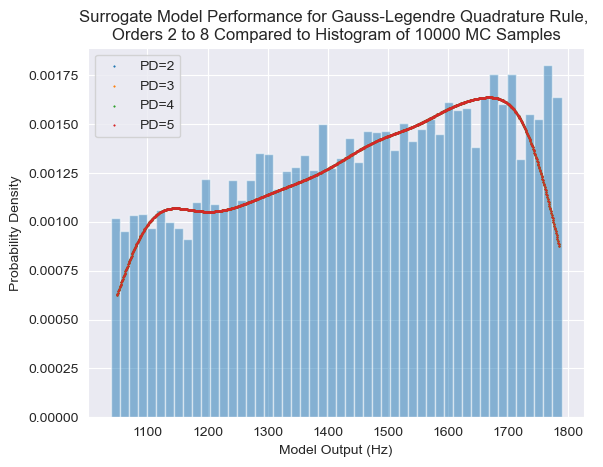

In [55]:
### PLOT SURROGATE PDF CONVERGENCE BANDGAP SIZE ###
plt.figure()
plt.hist(bg_size_1d_E_soft_mc_sample_sets[10000], bins=50, density=True, alpha=0.5)
for d in degrees:
    plot_label = 'PD='+str(d)
    plt.scatter(np.linspace(np.min(E_soft_surrogate_outputs_bgs[d]), np.max(E_soft_surrogate_outputs_bgs[d]), 1000), E_soft_surrogate_pdf_bgs[d], label=plot_label, s=1, linewidths=0.5)
plt.xlabel("Model Output (Hz)")
plt.ylabel("Probability Density")
title_str = 'Surrogate Model Performance for Gauss-Legendre Quadrature Rule, \nOrders 2 to 8 Compared to Histogram of 10000 MC Samples'
plt.title(title_str)
plt.legend(loc='best')

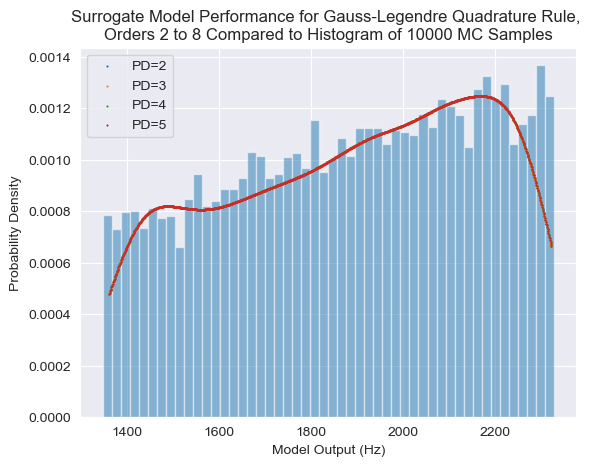

In [59]:
### PLOT SURROGATE PDF CONVERGENCE BANDGAP LOCATION ###
plt.figure()
plt.hist(bg_center_1d_E_soft_mc_sample_sets[10000], bins=50, density=True, alpha=0.5)
for d in degrees:
    plot_label = 'PD='+str(d)
    plt.scatter(np.linspace(np.min(E_soft_surrogate_outputs_bgc[d]), np.max(E_soft_surrogate_outputs_bgc[d]), 1000), E_soft_surrogate_pdf_bgc[d], label=plot_label, s=1, linewidths=0.5)
plt.xlabel("Model Output (Hz)")
plt.ylabel("Probability Density")
title_str = 'Surrogate Model Performance for Gauss-Legendre Quadrature Rule, \nOrders 2 to 8 Compared to Histogram of 10000 MC Samples'
plt.title(title_str)
plt.legend(loc='best')

Individual Input Variations - Bandgap Size - E_hard

In [138]:
N_1d_mc_E_hard = [100, 1000, 10000]
sample_1d_mc_E_hard_sets = {}
for N in N_1d_mc_E_hard:
    sample_1d_mc_E_hard = E_hard_dist.sample(N)
    sample_1d_mc_E_hard_sets[N] = sample_1d_mc_E_hard
    savemat('E_hard_dist_mc'+str(N)+'.mat',{'mc_'+str(N)+'_inputs':sample_1d_mc_E_hard})

In [ ]:
E_hard_1d_mc_sample_sets = {}
bg_size_1d_E_hard_mc_sample_sets = {}
bg_top_1d_E_hard_mc_sample_sets = {}
bg_bottom_1d_E_hard_mc_sample_sets = {}
bg_center_1d_E_hard_mc_sample_sets = {}

for N in N_1d_mc_E_hard:
    folder_name = 'mc_E_hard'
    file_suffix = '_uniform_mc'+str(N)+'.mat'
    E_hard_file = loadmat(folder_name+'/E_hard'+file_suffix)
    bg_size_1d_E_hard_file = loadmat(folder_name+'/bg_size'+file_suffix)
    bg_top_1d_E_hard_file = loadmat(folder_name+'/bg_top'+file_suffix)
    bg_bottom_1d_E_hard_file = loadmat(folder_name+'/bg_bottom'+file_suffix)

    E_hard_sample_sets[N] = E_hard_file['E_hard'][:]
    bg_size_1d_E_hard_mc_sample_sets[N] = bg_size_1d_E_hard_file['bg_size'][:]
    bg_top_1d_E_hard_mc_sample_sets[N] = bg_top_1d_E_hard_file['bg_top'][:]
    bg_bottom_1d_E_hard_mc_sample_sets[N] = bg_bottom_1d_E_hard_file['bg_bottom'][:]
    bg_center_1d_E_hard_mc_sample_sets[N] = (bg_top_1d_E_hard_mc_sample_sets[N] + bg_bottom_1d_E_hard_mc_sample_sets[N])/2

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharey=False, tight_layout=True, figsize=(12,6))
axs[0,0].hist(sample_1d_mc_E_hard_sets[100].T, bins=50, density=True, alpha=0.5)
axs[0,1].hist(sample_1d_mc_E_hard_sets[1000].T, bins=50, density=True, alpha=0.5)
axs[0,2].hist(sample_1d_mc_E_hard_sets[10000].T, bins=50, density=True, alpha=0.5)
axs[1,0].hist(bg_size_1d_E_hard_mc_sample_sets[100], bins=50, density=True, alpha=0.5)
axs[1,1].hist(bg_size_1d_E_hard_mc_sample_sets[1000], bins=50, density=True, alpha=0.5)
axs[1,2].hist(bg_size_1d_E_hard_mc_sample_sets[10000], bins=50, density=True, alpha=0.5)

axs[0,0].set_xlabel("Stiffness (Pa)")
axs[0,0].set_ylabel("Probability Density")
axs[0,0].set_title('E_hard, N=20')

axs[0,1].set_xlabel("Stiffness (Pa)")
#axs[0,1].set_ylabel("Probability Density")
axs[0,1].set_title('E_hard, N=100')

axs[0,2].set_xlabel("Stiffness (Pa)")
#axs[0,2].set_ylabel("Probability Density")
axs[0,2].set_title('E_hard, N=500')

axs[1,0].set_xlabel("Frequency (Hz)")
axs[1,0].set_ylabel("Probability Density")
axs[1,0].set_title('Bandgap Size, N=20')

axs[1,1].set_xlabel("Frequency (Hz)")
#axs[1,1].set_ylabel("Probability Density")
axs[1,1].set_title('Bandgap Size, N=100')

axs[1,2].set_xlabel("Frequency (Hz)")
#axs[1,2].set_ylabel("Probability Density")
axs[1,2].set_title('Bandgap Size, N=500')

title_str = 'Histograms of 20, 100,& 500 MC Samples Of E_hard & Bandgap Size'
fig.suptitle(title_str)

In [ ]:
quadrature_1d_surrogates_E_hard = {}
quadrature_1d_nodes_E_hard = {}
quadrature_1d_weights_E_hard = {}
for d in degrees:
    nodes, weights = cp.generate_quadrature(d, E_hard_dist, rule='G')
    quadrature_1d_nodes_E_hard[d] = nodes
    quadrature_1d_weights_E_hard[d] = weights

for qd in quadrature_1d_nodes_E_hard:
    savemat('E_hard_dist_q_pd'+str(qd)+'.mat',{'pd_'+str(qd)+'_inputs':quadrature_1d_nodes_E_hard[qd]})

In [ ]:
E_hard_sample_sets = {}
bg_size_1d_E_hard_sample_sets = {}
bg_top_1d_E_hard_sample_sets = {}
bg_bottom_1d_E_hard_sample_sets = {}
bg_center_1d_E_hard_sample_sets = {}

for d in degrees:
    folder_name = 'quad_E_hard'
    file_suffix = '_uniform_q_pd'+str(d)+'.mat'
    E_hard_file = loadmat(folder_name+'/E_hard'+file_suffix)
    bg_size_1d_E_hard_file = loadmat(folder_name+'/bg_size'+file_suffix)
    bg_top_1d_E_hard_file = loadmat(folder_name+'/bg_top'+file_suffix)
    bg_bottom_1d_E_hard_file = loadmat(folder_name+'/bg_bottom'+file_suffix)

    E_hard_sample_sets[d] = E_hard_file['E_hard'][:]
    bg_size_1d_E_hard_sample_sets[d] = bg_size_1d_E_hard_file['bg_size'][:]
    bg_top_1d_E_hard_sample_sets[d] = bg_top_1d_E_hard_file['bg_top'][:]
    bg_bottom_1d_E_hard_sample_sets[d] = bg_bottom_1d_E_hard_file['bg_bottom'][:]
    bg_center_1d_E_hard_sample_sets[d] = (bg_top_1d_E_hard_sample_sets[d] + bg_bottom_1d_E_hard_sample_sets[d])/2

In [ ]:
q_1d_E_hard_surrogates_bgs = {}

for degree in degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=E_hard_dist,
        normed=True
    )
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=quadrature_1d_nodes_E_hard[degree],
        weights=quadrature_1d_weights_E_hard[degree],
        solves=bg_size_1d_E_hard_sample_sets[degree]
    )
    q_1d_E_hard_surrogates_bgs[degree] = polynomial_approximation

In [ ]:
q_1d_E_hard_surrogates_bgc = {}

for degree in degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=E_hard_dist,
        normed=True
    )
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=quadrature_1d_nodes_E_hard[degree],
        weights=quadrature_1d_weights_E_hard[degree],
        solves=bg_center_1d_E_hard_sample_sets[degree]
    )
    q_1d_E_hard_surrogates_bgc[degree] = polynomial_approximation

Individual Input Variations - Bandgap Size - rho_hard

In [139]:
N_1d_mc_rho_soft = [100, 1000, 10000]
sample_1d_mc_rho_soft_sets = {}
for N in N_1d_mc_rho_soft:
    sample_1d_mc_rho_soft = rho_soft_dist.sample(N)
    sample_1d_mc_rho_soft_sets[N] = sample_1d_mc_rho_soft
    savemat('rho_soft_dist_mc'+str(N)+'.mat',{'mc_'+str(N)+'_inputs':sample_1d_mc_rho_soft})

Individual Input Variations - Bandgap Size - rho_hard

In [140]:
N_1d_mc_rho_hard = [100, 1000, 10000]
sample_1d_mc_rho_hard_sets = {}
for N in N_1d_mc_rho_hard:
    sample_1d_mc_rho_hard = rho_hard_dist.sample(N)
    sample_1d_mc_rho_hard_sets[N] = sample_1d_mc_rho_hard
    savemat('rho_hard_dist_mc'+str(N)+'.mat',{'mc_'+str(N)+'_inputs':sample_1d_mc_rho_hard})

Individual Input Variations - Bandgap Size - pr_soft

In [141]:
N_1d_mc_pr_soft = [100, 1000, 10000]
sample_1d_mc_pr_soft_sets = {}
for N in N_1d_mc_pr_soft:
    sample_1d_mc_pr_soft = pr_soft_dist.sample(N)
    sample_1d_mc_pr_soft_sets[N] = sample_1d_mc_pr_soft
    savemat('pr_soft_dist_mc'+str(N)+'.mat',{'mc_'+str(N)+'_inputs':sample_1d_mc_pr_soft})

Individual Input Variations - Bandgap Size - pr_hard

In [142]:
N_1d_mc_pr_hard = [100, 1000, 10000]
sample_1d_mc_pr_hard_sets = {}
for N in N_1d_mc_pr_hard:
    sample_1d_mc_pr_hard = pr_hard_dist.sample(N)
    sample_1d_mc_pr_hard_sets[N] = sample_1d_mc_pr_hard
    savemat('pr_hard_dist_mc'+str(N)+'.mat',{'mc_'+str(N)+'_inputs':sample_1d_mc_pr_hard})

Individual Input Variations - Bandgap Size - pr_hard

Individual Input Variations - Bandgap Top

Individual Input Variations - Bandgap Bottom

Individual Input Variations - Bandgap Center